In [1]:
%matplotlib inline 
%matplotlib nbagg
import lasagne
import theano
import theano.tensor as T
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator import get_batch, print_valid_characters


Couldn't import dot_parser, loading of dot files will not be possible.


# Recurrent Neural Networks

Recurrent neural networks are the natural type of neural network to use for sequential data i.e. time series analysis, translation, speech recognition, biological sequence analysis etc. Recurrent neural networks works by recursively applying the same operation at each time step of the data sequence and having layers that pass information from previous time step to the current. It can therefore naturally handle input of varying length. Recurrent networks can be used for several prediction tasks including: sequence-to-class, sequence tagging, and sequence-to-sequence predictions.

In this exercise we'll implement a Encoder-Decoder RNN based on the GRU unit for a simple sequence to sequence translation task. This type of models have shown impressive performance in Neural Machine Translation and Image Caption generation. 

For more in depth background material on RNNs please see [Supervised Sequence Labelling with Recurrent
Neural Networks](https://www.cs.toronto.edu/~graves/preprint.pdf) by Alex Graves

We know that LSTMs and GRUs are difficult to understand. A very good non-mathematical introduction is [Chris Olahs blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). (All the posts are nice and cover various topics within machine-leanr)

# Encoder-Decoder
In the encoder-decoder structure one RNN (blue) encodes the input and a second RNN (red) calculates the target values. One essential step is to let the encoder and decoder communicate. In the simplest approach you use the last hidden state of the encoder to initialize the decoder. Other approaches lets the decoder attend to different parts of the encoded input at different timesteps in the decoding process. 

<img src="files/enc-dec.png", width=400>

In our implementation we use a RNN with gated recurrent units (GRU) as encoder. We then use the last hidden state of the encoder ($h^{enc}_T$) as input to the decoder which is also a GRU RNN. 

### RNNs in Lasagne
Lasagne have implementations of LSTM and GRU unit. Both layers assume that the input from the layer below have the shape **(Batch_size, seq_len, num_features)**. In this excercise we will use the GRU unit since it only stores a single hidden value per neuron (LSTMs stores two) and is approximately twice as fast as the LSTM unit.

As stated above we will implement a Encoder-Decoder model. The simplest way to do this is to encode the input sequence using the Encoder model. We will then use the last hidden state of the Encoder $h^{enc}_T$ as input to the decoder model which then uses this information (simply a fixed length vector of numbers) to produce the targets. There is (at least) two ways to input $h^{enc}_T$ into the decoder

1. Repeatly use $h^{enc}_T$ as input to the Decoder at each decode time step
2. Intialize the decoder using $h^{enc}_T$ and run the decoder without any inputs

In this exercise we will follow the first approach because it's easier to implement. To do this need to create a lasagne layer that takes $h^{enc}_T$ and repeat it *N_decode_step* times. Below is an implementation of the RepeatLayer. You don't need to know the exact way it works, however make sure that you understand that it takes an input is size *(Batch_size x num_units)* and produces an output of size (Batch_size x n_decode_steps x num_units).


In [2]:
class RepeatLayer(lasagne.layers.Layer):
    def __init__(self, incoming, n, **kwargs):
        '''
        The input is expected to be a 2D tensor of shape 
        (num_batch, num_features). The input is repeated
        n times such that the output will be 
        (num_batch, n, num_features)
        '''
        super(RepeatLayer, self).__init__(incoming, **kwargs)
        self.n = n

    def get_output_shape_for(self, input_shape):
        return tuple([input_shape[0], self.n] + list(input_shape[1:]))

    def get_output_for(self, input, **kwargs):
        #repeat the input n times
        tensors = [input]*self.n
        stacked = theano.tensor.stack(*tensors)
        dim = [1, 0] + range(2, input.ndim + 1)
        return stacked.dimshuffle(dim)

### The Data
Since RNN models can be very slow to train on real large datasets we will generate some simpler training data for this exercise. The task for the RNN is simply to translate a string of letters spelling the numbers between 0-9 into the corresponding numbers i.e

"one two five" --> "125#" (we use # as a special stop of sequence character)

To input the strings into the RNN model we translate the characters into a vector integers using a simple translation table (i.e. 'h'->16, 'o'-> 17 etc). The code below prints a few input/output pairs using the *get_batch* function which randomy produces the data.

In [3]:
batch_size = 3
inputs, input_masks, targets, target_masks, text_inputs, text_targets = \
    get_batch(batch_size=batch_size,max_digits=2,min_digits=1)

print "input types:", inputs.dtype,  input_masks.dtype, targets.dtype, target_masks.dtype
print print_valid_characters()
print "Stop character = #"

for i in range(batch_size):
    print "\nSAMPLE",i
    print "TEXT INPUTS:\t\t", text_inputs[i]
    print "TEXT TARGETS:\t\t", text_targets[i]
    print "ENCODED INPUTS:\t\t", inputs[i]
    print "MASK INPUTS:\t\t", input_masks[i]
    print "ENCODED TARGETS:\t", targets[i]
    print "MASK TARGETS:\t\t", target_masks[i]

input types: int32 float32 int32 float32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	' '=11,	'e'=12,	'g'=13,	'f'=14,	'i'=15,	'h'=16,	'o'=17,	'n'=18,	's'=19,	'r'=20,	'u'=21,	't'=22,	'w'=23,	'v'=24,	'x'=25,	'z'=26,	
None
Stop character = #

SAMPLE 0
TEXT INPUTS:		six
TEXT TARGETS:		6#
ENCODED INPUTS:		[19 15 25  0]
MASK INPUTS:		[ 1.  1.  1.  0.]
ENCODED TARGETS:	[ 6 10  0]
MASK TARGETS:		[ 1.  1.  0.]

SAMPLE 1
TEXT INPUTS:		zero
TEXT TARGETS:		0#
ENCODED INPUTS:		[26 12 20 17]
MASK INPUTS:		[ 1.  1.  1.  1.]
ENCODED TARGETS:	[ 0 10  0]
MASK TARGETS:		[ 1.  1.  0.]

SAMPLE 2
TEXT INPUTS:		six
TEXT TARGETS:		6#
ENCODED INPUTS:		[19 15 25  0]
MASK INPUTS:		[ 1.  1.  1.  0.]
ENCODED TARGETS:	[ 6 10  0]
MASK TARGETS:		[ 1.  1.  0.]


### Encoder Decoder model setup
Below is the Lasagne model definition. We use an embedding layer to go from integer representation to vector representation of the input.

Note that the layer has a lot of print statements which we used for debugging during setup.

In [4]:
BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()

#dummy data to test implementation - We advise to check the output-dimensions of all layers.
#One way to do this in lasagne/theano is to forward pass some data through the model and 
#check the output dimensions of these.
#Create some random testdata
X = np.random.randint(0,10,size=(BATCH_SIZE,MIN_DIGITS)).astype('int32')
Xmask = np.ones((BATCH_SIZE,MIN_DIGITS)).astype('float32')

##### ENCODER START #####
l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line
l_emb.params[l_emb.W].remove('trainable') 
#forward pass some data throug the inputlayer-embedding layer and print the output shape
print lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).eval({x_sym: X}).shape

l_mask_enc = lasagne.layers.InputLayer((None, None))
l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder', mask_input=l_mask_enc)
print lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

# slice last index of dimension 1
l_last_hid = lasagne.layers.SliceLayer(l_enc, indices=-1, axis=1)
print lasagne.layers.get_output(l_last_hid, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
##### END OF ENCODER######


##### START OF DECODER######
l_in_rep = RepeatLayer(l_last_hid, n=MAX_DIGITS+1) #we add one to allow space for the end of sequence character
print lasagne.layers.get_output(l_in_rep, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

l_dec = lasagne.layers.GRULayer(l_in_rep, num_units=NUM_UNITS_DEC, name='GRUDecoder')
print lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape


# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 
# In short this line changes the shape from 
# (batch_size, decode_len, num_dec_units) -> (batch_size*decodelen,num_dec_units). 
# We need to do this since the softmax is applied to the last dimension and we want to 
# softmax the output at each position individually
l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
print lasagne.layers.get_output(l_reshape, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
print lasagne.layers.get_output(l_softmax, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

# reshape back to 3d format (batch_size, decode_len, num_dec_units). Here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model.
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
print lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
###END OF DECODER######

(100, 20, 27)
(100, 20, 10)
(100, 10)
(100, 21, 10)
(100, 21, 10)
(2100, 10)
(2100, 11)
(100, 21, 11)


### Defining the cost function and theano functions
Becasue the targets are categorical we use cross entropy error. We use the Adam optimizer but you
can experiment with the different optimizers implemented in [Lasagne](http://lasagne.readthedocs.org/en/latest/modules/updates.html). 

In [5]:
output_decoder_train = lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, 
                                                deterministic=False)

#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
argmax = T.argmax(output_decoder_train,axis=-1)
eq = T.eq(argmax,y_sym)
acc = T.mean(eq)  # gives float64 because eq is uint8, T.cast(eq, 'float32') will fix that...

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params([l_out], trainable=True)

print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]
all_grads = lasagne.updates.total_norm_constraint(all_grads,3)

#Compile Theano functions.
#The two first two inputs to theano.functions is 
#1) a list of theano shared variables and 
#2) a list of functions(graphs) to calculate the values of most importanly the cost function. 
#3) for the training function the update argument should be given as the output from one of 
#4) lasagnes optimizers. of this argument is not set no parameters will be updated and only the values if 2) will be calculated
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train])

/Users/sorensonderby/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/pfunc.py:95: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  [clone_d[i] for i in owner.inputs], strict=rebuild_strict)
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/function_module.py:177: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  update_mapping=update_mapping)
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/function_module.py:1456: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={

Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
GRUDecoder.W_in_to_updategate (10, 10)
GRUDecoder.W_hid_to_updategate (10, 10)
GRUDecoder.b_updategate (10,)
GRUDecoder.W_in_to_resetgate (10, 10)
GRUDecoder.W_hid_to_resetgate (10, 10)
GRUDecoder.b_resetgate (10,)
GRUDecoder.W_in_to_hidden_update (10, 10)
GRUDecoder.W_hid_to_hidden_update (10, 10)
GRUDecoder.b_hidden_update (10,)
SoftmaxOutput.W (10, 11)
SoftmaxOutput.b (11,)
----------------------------------------


In [6]:
#Generate some validation data
Xval, Xmask_val, Yval, Ymask_val, text_inputs_val, text_targets_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print "Xval", Xval.shape
print "Yval", Yval.shape

Xval (5000, 112)
Yval (5000, 21)


# Training

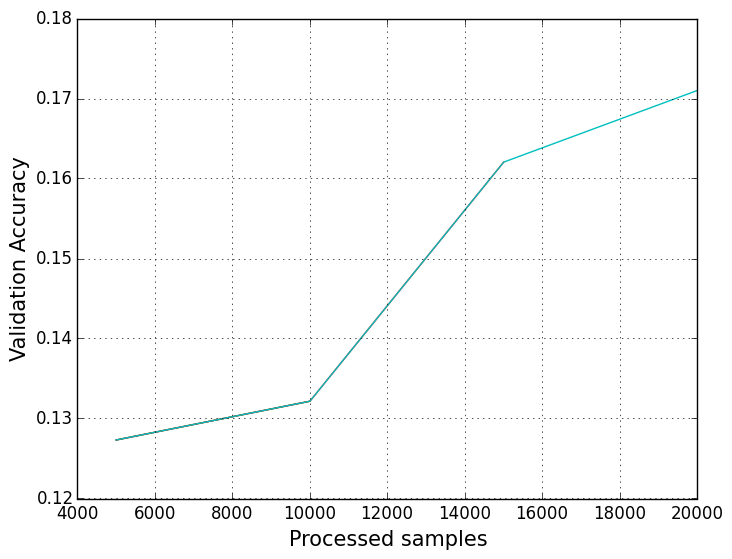

In [7]:
val_interval = 5000
samples_to_process = 3e5
samples_processed = 0

val_samples = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        x_, x_masks_, ys_, y_masks_, _, _ = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        batch_cost, batch_acc, batch_output = train_func(x_, ys_, x_masks_)
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            val_acc, val_output = test_func(Xval, Yval, Xmask_val)
            val_samples += [samples_processed]
            accs += [val_acc]
            plt.plot(val_samples,accs)
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.show()
except KeyboardInterrupt:
    pass

<IPython.core.display.Javascript object>


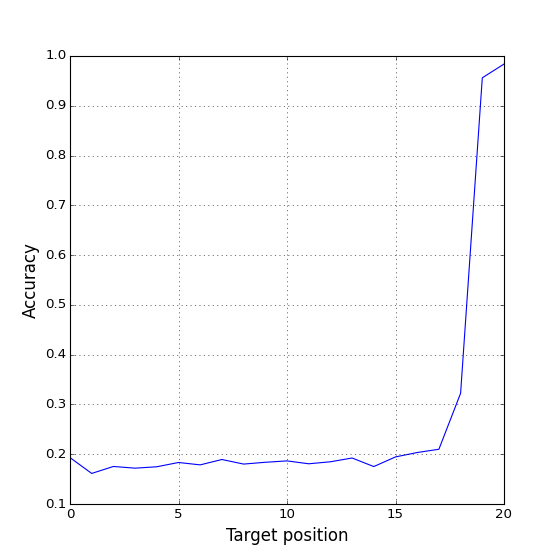

In [25]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(val_output,axis=2)==Yval,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

In [ ]:
# plot training cost
#plt.figure(figsize=(7,7))
#plt.plot(costs)
#plt.ylabel('Cost', fontsize=15)
#plt.xlabel('Number of updates', fontsize=15)
#plt.title('Training', fontsize=20)
#plt.show()

# Exercises:
1. The model has two GRU networks. The ```GRUEncoder``` and the ```GRUDecoder```. A GRU is parameterized by the  ```{W_in_to_updategate, W_hid_to_updategate, b_updategate, W_in_to_resetgate, W_hid_to_resetgate, b_resetgate,
W_in_to_hidden_update, W_hid_to_hidden_update,b_hidden_update}```. Try to explain the shape of ```W_in_to_updategate``` and ```hid_to_updategate```. Why are they different? You can find the equations for the gru at: [GRU](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer). 
2. The GRUunit is able to ignore the input and just copy the previous hidden state. In the begining of training this might be desireable behavioru because it helps the model learn long range dependencies. You can make the model ignore the input by modifying initial bias values. What bias would you modify and how would you modify it? Again you'll need to refer to the GRU equations:  [GRU](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer)

2. What is the final validation performance? Why do you think it is not better? Comment on the accuracy for each position in of the output symbols?

3. Why do you think the validation performance looks more "jig-saw" like compared to FFN and CNN models?

4. In the example we stack a softmax layer on top of a Recurrent layer. In the code snippet below explain how we can do that?

In [14]:
bs_, seqlen_, numinputs_ = 16, 140, 40
l_input_ = lasagne.layers.InputLayer((bs_, seqlen_, numinputs_))
l_gru_ = lasagne.layers.GRULayer(l_input_, num_units=10)
l_reshape_ = lasagne.layers.ReshapeLayer(l_gru_, (-1, [2])) # the [2] tells lasagne to use the dim of the 2. 
                                                            # dim of the input here. -1 is a wildcard
l_softmax_ = lasagne.layers.DenseLayer(l_reshape_, num_units=11, 
                                      nonlinearity=lasagne.nonlinearities.softmax)
l_softmax_seq_ = lasagne.layers.ReshapeLayer(l_softmax_,(bs_, seqlen_, -1))
print "l_input_", l_input_.output_shape
print "l_gru_", l_gru_.output_shape
print "l_reshape_", l_reshape_.output_shape
print "l_softmax_", l_softmax_.output_shape
print "l_softmax_seq_", l_softmax_seq_.output_shape

l_input_ (16, 8, 32)
l_gru_ (16, 8, 10)
l_reshape_ (128, 10)
l_softmax_ (128, 11)
l_softmax_seq_ (16, 8, 11)


6. Optional: You are interested in doing sentiment analysis on tweets, i.e classification as positive or negative. You decide read over the twitter seqeuence and use the last hidden state to do the classification. How can you modify the small network above to only outa single classification for network? Hints: Look at the SliceLayer or the GRU docs...


7. Optional: Bidirectional Encoder, In Lasagne bidirectional RNNs are implementated by running a forward model and a backward model separately and then concatenating them before parsing them on to the next layer. You can experiment with using a different merging layer than concat e.g. sum or multiplication see [lasagne merge layers [lasagne merge layers](http://lasagne.readthedocs.org/en/latest/modules/layers/merge.html).

```
l_rec_fwd = lasagne.layers.GRULayer(...,backwards=False)
l_rec_bwd = lasagne.layers.GRULayer(...,backwards=True)
l_rec = lasagne.layers.ConcatLayer([l_rec_fwd, l_rec_bwd], axis=2))
```

8. Optional: Add support for different lengths of targets (hint: add the target_mask to the cost function and only calculate the cost for the non-masked targets)


## Attention Decoder (LSTM)
Selective attention for recurrent neural networks have recently attracted a lot of interest. These methods let the Decoder model selective focus on which part of the encoder sequence it will use for each decoded output symbol. This relieves the encoder from having to compress the input sequence into a fixed size vector representation passed on to the decoder. Secondly we can interrogate the decoder network about where it attends while producing the ouputs. below we'll implement an LSTM-decoder with selective attention and show that it significantly improves the performance of the toy translation task.

The siminal attention paper is https://arxiv.org/pdf/1409.0473v7.pdf

The principle of attention models is simple. 

1. Use the encoder to get the hidden represention $\{h^1_e, ...h^n_e\}$ for each position in the input sequence. 
2. for timestep $t$ in the decoder do for $m = 1...n$ : $a_m = f(h^m_e, h^d_t)$. Where f is a function returning a scalar value. 
3. You can then normalize the sequence of scalars $\{a_1, ... a_n\}$ to get probablities $\{p_1, ... p_n\}$.
4. Weight each $h^e_t$ by its probablity $p_t$ and sum to get $h_{in}$.
5. Use $h_{in}$ as an additional input to the decoder. $h_{in}$ is recalculated each time the decoder is updated.

In [8]:
from decoder_attention import LSTMAttentionDecodeFeedbackLayer

# you can acces the attetion weights alpha by adding l_dec.alpha 
# to the output variables in the theano function

BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()
    

#dummy data to test implementation
#X = np.random.randint(0,10,size=(BATCH_SIZE,15)).astype('int32')
#Xmask = np.ones((BATCH_SIZE,NUM_INPUTS)).astype('float32')

l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
##### ENCODER START #####
l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line
l_emb.params[l_emb.W].remove('trainable') 
print lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).eval(
    {x_sym: X}).shape
T.grad(lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).sum(), 
       lasagne.layers.get_all_params(l_emb, trainable=True))




l_mask_enc = lasagne.layers.InputLayer((None, None))
l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder', mask_input=l_mask_enc)
print lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_enc, trainable=True))
####END OF ENCODER######


####START OF DECODER######
#note that the decoder have its own input layer, we'll use that to plug in the output 
#from the encoder later
l_dec = LSTMAttentionDecodeFeedbackLayer(l_enc,
                                        num_units=NUM_UNITS_DEC, 
                                        aln_num_units=20,
                                        n_decodesteps=MAX_DIGITS+1,
                                        name='LSTMDecoder')
print lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_dec, trainable=True))

# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 
l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
# print lasagne.layers.get_output(l_softmax, x_sym).eval({x_sym: X}).shape
# reshape back to 3d format (here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model)
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
print lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, deterministic=False).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_dec, trainable=True))

print ""
###END OF DECODER######



(100, 20, 27)
(100, 20, 10)
(100, 21, 10)
(100, 21, 11)



In [9]:
#Generate some validation data
Xval, Xmask_val, Yval, Ymask_val, text_inputs_val, text_targets_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)

In [10]:
#get output of encoder using X and Xmask as input
output_decoder_train = lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, 
                                                 deterministic=False)

#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
acc = T.mean(T.eq(T.argmax(output_decoder_train,axis=-1),y_sym))

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params(l_out, trainable=True)

print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]
all_grads = lasagne.updates.total_norm_constraint(all_grads,3)

#Compile Theano functions
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train, l_dec.alpha])


Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
LSTMDecoder.W_hid_to_ingate (10, 10)
LSTMDecoder.b_ingate (10,)
LSTMDecoder.W_hid_to_forgetgate (10, 10)
LSTMDecoder.b_forgetgate (10,)
LSTMDecoder.W_hid_to_cell (10, 10)
LSTMDecoder.b_cell (10,)
LSTMDecoder.W_hid_to_outgate (10, 10)
LSTMDecoder.b_outgate (10,)
LSTMDecoder.W_weightedhid_to_ingate (10, 10)
LSTMDecoder.W_weightedhid_to_forgetgate (10, 10)
LSTMDecoder.W_weightedhid_to_cell (10, 10)
LSTMDecoder.W_weightedhid_to_outgate (10, 10)
LSTMDecoder.W_cell_to_ingate (10,)
LSTMDecoder.W_cell_to_forgetgate (10,)
LSTMDecoder.W_cell_to_outgate (10,)
LSTMDecoder.AlignSeqOutputLayer: (aln) W_a (

/Users/sorensonderby/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.


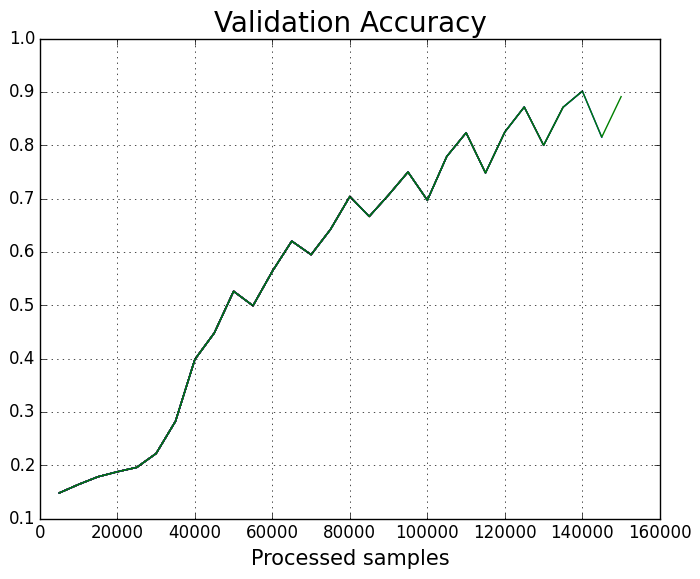

In [11]:
val_interval = 5000
samples_to_process = 1.5e5
samples_processed = 0
val_samples = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        inputs, input_masks, targets, target_masks, _, _ = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        batch_cost, batch_acc, batch_output = train_func(inputs, targets, input_masks)
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #print i, samples_processed
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            val_acc, val_output, alpha = test_func(Xval, Yval, Xmask_val)
            val_samples += [samples_processed]
            accs += [val_acc]
            plt.plot(val_samples,accs)
            plt.ylabel('', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('Validation Accuracy', fontsize=20)
            plt.grid('on')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.show()
except KeyboardInterrupt:
    pass
        

<IPython.core.display.Javascript object>


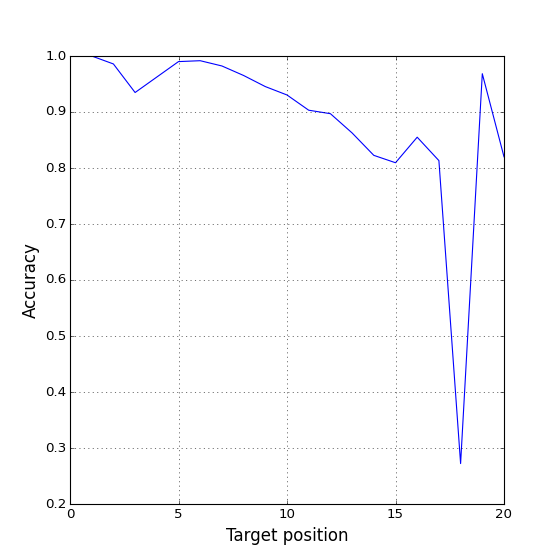

In [12]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(val_output,axis=2)==Yval,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

<IPython.core.display.Javascript object>


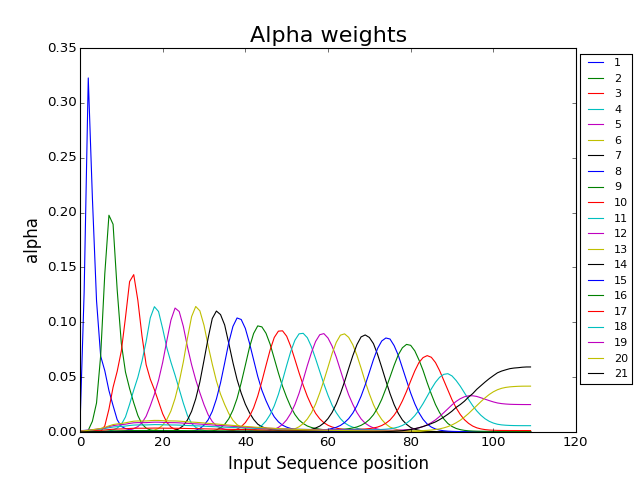

In [13]:
#Plot of average attention weight as a function of the sequence position for each of 
#the 21 targets in the output sequence i.e. each line is the mean postion of the 
#attention for each target position.

np.mean(alpha,axis=0).shape
plt.figure()
plt.plot(np.mean(alpha,axis=0).T)
plt.ylabel('alpha', fontsize=15)
plt.xlabel('Input Sequence position', fontsize=15)
plt.title('Alpha weights', fontsize=20)
plt.legend(map(str,range(1,22)), bbox_to_anchor=(1.125,1.0), fontsize=10)
plt.show()


## Assignments for the attention decoder
1. Explain what the alphaweights show. 
2. Why are the alpha curve for the first digit narrow and peaked while later digits have alpha curves that are wider and less peaked?
3. Why is attention a good idea for this problem? Can you think of other problems where attention is a good choice?